In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6_new as ds
from copy import copy as dup
from scipy.integrate import odeint

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
#Setting up the system
nx = 501 # Number of points in simulation box
# nx = 1501 # Number of points in simulation box
xmax = 50
xmax = 150
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltaX = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot = np.ones(nx)
NQLL = ds.getNliq(Ntot,Nstar,Nbar)
Nice = Ntot-NQLL

<IPython.core.display.Javascript object>


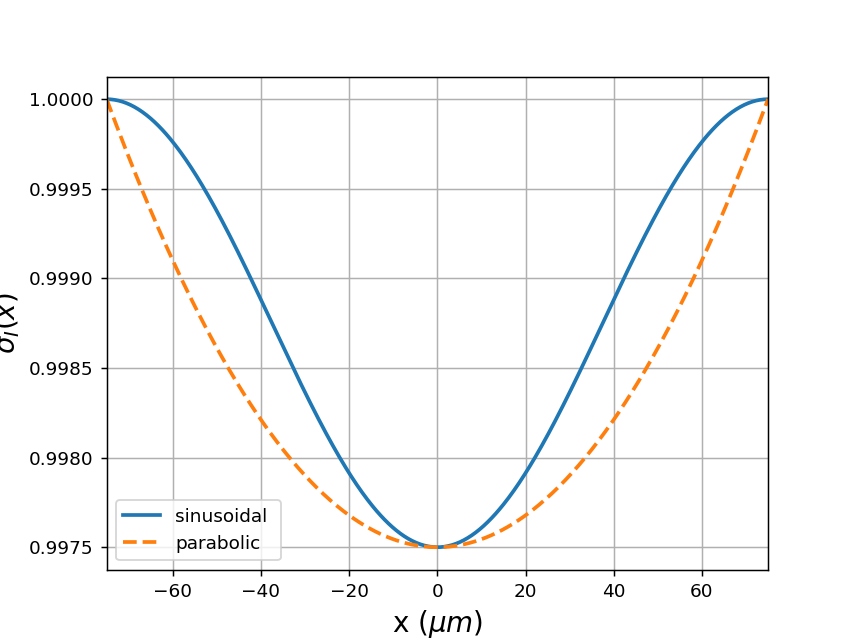

In [4]:
# Lay out the system
Ntot = NQLL + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
# D = 2e-4 # micrometers^2/microsecond
D = 1.6e-4 # micrometers^2/microsecond
# D = 2e-5 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltat = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 34 # microns/second - about right for 240 K
nu_kin = 49 # microns/second - between 240 and 260 K
nu_kin = 250 # microns/second - about right for 260 K
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltat = deprate * deltat

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth
sigmastepmax = 0.22 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid') #NOTE i think this should be nx not xmax
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
sigmastepstyle = 'sinusoid'
sigmastepstyle = 'parabolic'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print('bad choice')

# Graph sigma(x)
plt.figure()
plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
         x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [5]:
# These are run control parameters

# Flag for explicit updating NQLL(Ntot) every step
updatingNQLL = False

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 100
else:
    countermax_0D = 100

# 1D run 
if uselayers:
    layermax_1D = 1500
else:
    countermax_1D = 15000

In [6]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time)', dtmax)
print('deltat =', deltat)
print('deprate =', deprate, 'monolayers/us')
print('nmid', nmid)
print('N*', Nstar)
print('N*x2pi', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltaX', deltaX)
print('sigma_0 =', sigma0)
print('sigmastepmax =', sigmastepmax)
print('center reduction', center_reduction, '%')
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltaX)

D = 0.00016 um^2/us 0.16 x 10^-9 m^2/sec
deltat_max (Diffusion time) 562.4999999999999
deltat = 11.249999999999998
deprate = 0.8333333333333334 monolayers/us
nmid 250
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.3
sigma_0 = 0.19
sigmastepmax = 0.22
center reduction 0.25 %
max growth rate = 55.00000000000001 um/sec
min growth rate = 7.5 um/sec
nu_kin = 250 um/sec
dx = 0.3


<IPython.core.display.Javascript object>


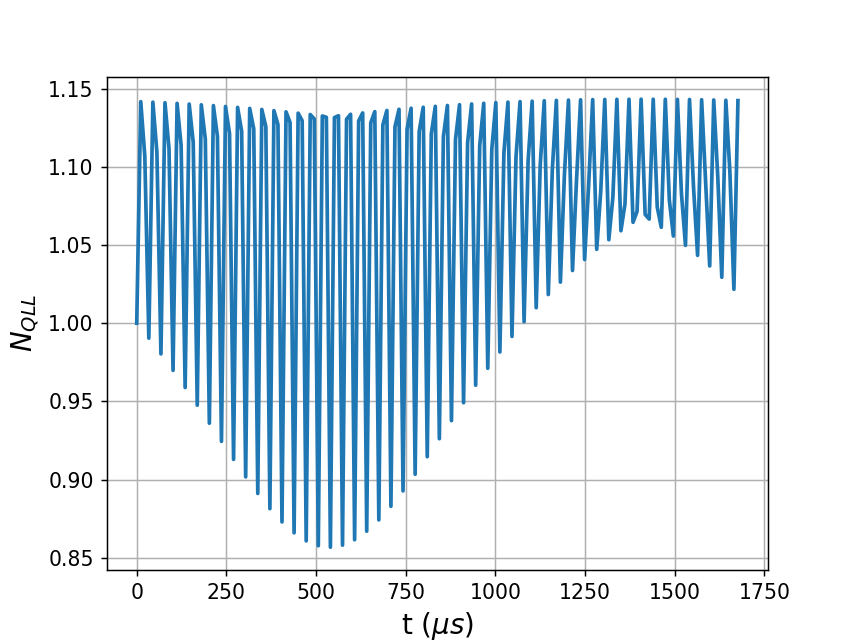

0-D Modeled growth rate, um/s 17.855521828136816
0-D Modeled growth rate, ml/us 0.05951840609378939
0-D Modeled alpha 0.3246458514206694


In [7]:
# This is the 0-d run
updatingNQLL = False

# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmastepmax, sigma0, deprate]

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to NQLL
    NQLLlast, Ntotlast = ylast
    Nicelast = Ntotlast - NQLLlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)

tkeep_0D_False = tkeep_0D
ykeep_0Darr_False = ykeep_0Darr

<IPython.core.display.Javascript object>


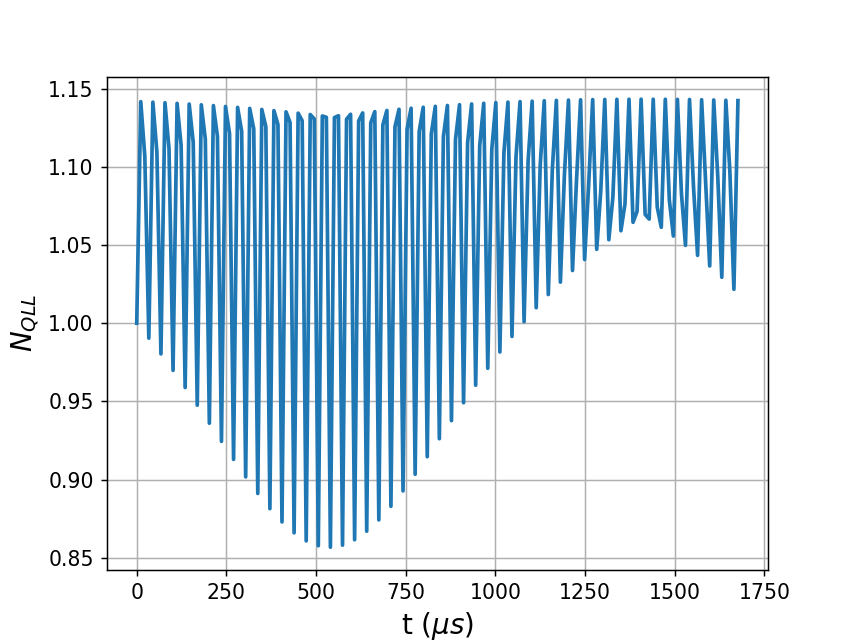

0-D Modeled growth rate, um/s 17.855521828136816
0-D Modeled growth rate, ml/us 0.05951840609378939
0-D Modeled alpha 0.3246458514206694


In [8]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmastepmax, sigma0, deprate]

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to NQLL
    NQLLlast, Ntotlast = ylast

    Nicelast = Ntotlast - NQLLlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)

tkeep_0D_True = tkeep_0D
ykeep_0Darr_True = ykeep_0Darr

<IPython.core.display.Javascript object>


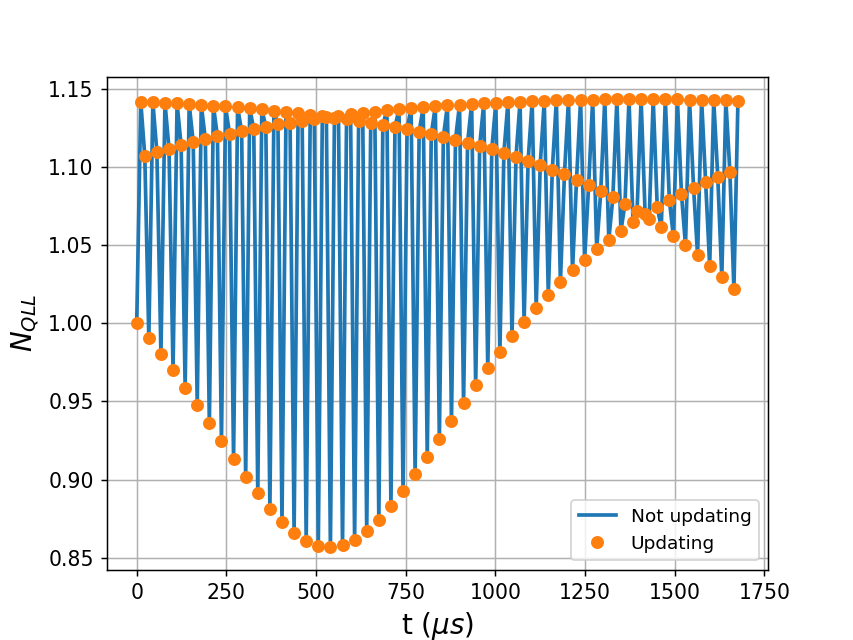

<IPython.core.display.Javascript object>


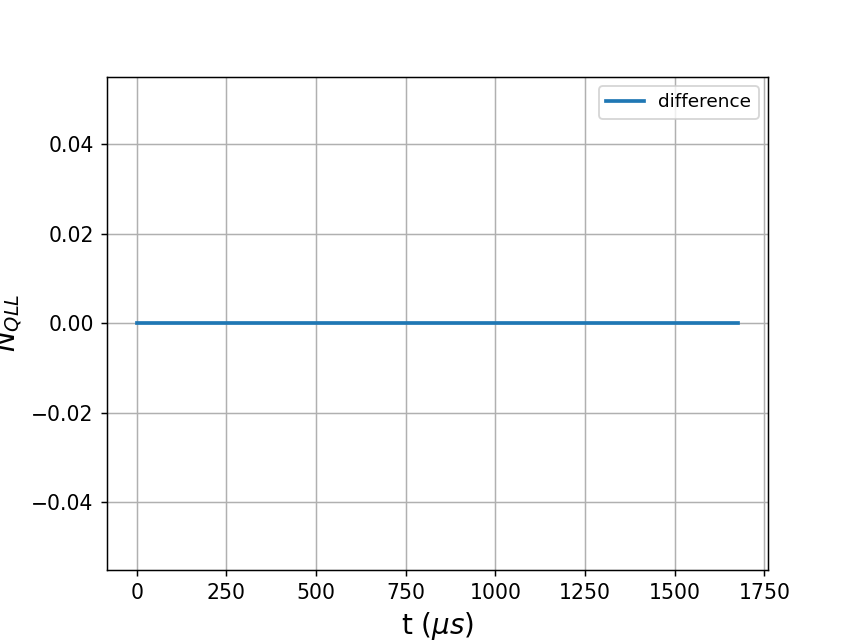

In [9]:
# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr_False[:,0],lw=linewidth,label='Not updating')
plt.plot(tkeep_0D,ykeep_0Darr_True[:,0],'o',lw=linewidth,label='Updating')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.legend()

plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr_False[:,0]-ykeep_0Darr_True[:,0],lw=linewidth,label='difference')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.legend()

In [10]:
#Parameters for 1-D run 
L = xmax/2; print(L) # micrometers
c_r = center_reduction / 100; print(c_r) # dimensionless
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
sigma_I = sigmastepmax; print('sigmaI ', sigma_I) # dimensionless
print(D, 'um^2/us') # D is in micrometers^2/microsecond
print(D*1e-6, 'm^2/s') # reporting as meters^2/second
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D
NSS = M*xfactor + B
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])

75.0
0.0025
0.8333333333333334
sigmaI  0.22
0.00016 um^2/us
1.6000000000000002e-10 m^2/s
sinusoid: 357.11646835877116
paraboloic: 329.5682114433066


In [11]:
# This is the 1-d run
updatingNQLL = False

# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmastep, sigma0, deprate, DoverdeltaX2, nx] 

# Initial conditions for ODE solver
y0 = np.array([NQLL,Ntot])
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
NQLLkeep = [dup(NQLL)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
counter = 0
lastlayer = 0
lastdiff = 0

while True:
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)

    ylast = np.reshape(y[1],(2,nx))
    tlast += deltat
    counter += 1
        
    # Make some local copies, with possible updates to NQLL
    NQLL, Ntot = ylast
    Nice = Ntot - NQLL
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltat

    # Stuff into keeper arrays
    Nicekeep.append(Nice)
    Ntotkeep.append(Ntot)
    NQLLkeep.append(NQLL)
    tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
    if uselayers:
        if layer > layermax_1D-1:
            print('breaking because reached max number of layers')
            break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

0 0 0.0028061187030752333
1 1 0.0031660225318808077
2 2 0.0632258934509431
4 3 0.008593079225673872
5 4 0.12184459587495056
7 5 0.013840671815984251
8 6 0.17631086289372888
10 7 0.018865401237109225
11 8 0.22719641551477388
13 9 0.02362791295611899
14 10 0.2750296880863665
16 11 0.02809526019250619
17 12 0.32021896496722313
19 13 0.03225934998291713
20 14 0.36307710692334716
22 15 0.03617365134774353
23 16 0.40383698504813026
25 17 0.04001718197137194
26 18 0.442654897683429
28 19 0.04420559323027362
29 20 0.4796182280657213
31 21 0.04956765087867865
32 22 0.5147712675274434
34 23 0.05757614011120182
35 24 0.548134371787544
37 25 0.07054175590338829
38 26 0.5797068826957386
40 27 0.09151704252582249
41 28 0.6094751219082113
43 29 0.12354104687758394
44 30 0.637428693445532
46 31 0.168164006085064
47 32 0.6635669592575866
49 33 0.22411406198194328
50 34 0.6879066641857179
52 35 0.28741227785200607
53 36 0.7104829317212378
55 37 0.353035838096325
56 38 0.7313496303601354
58 39 0.41671220

470 313 1.7580628554119926
471 314 1.9041426905978938
473 315 1.7701553872093996
474 316 1.905454656240181
476 317 1.781037830162063
477 318 1.9067960872463345
479 319 1.7908403722822186
480 320 1.9081703973092203
482 321 1.799677787127166
483 322 1.9095661270949336
485 323 1.8076510365789886
486 324 1.910946939549774
488 325 1.8148488484894187
489 326 1.912236399199628
491 327 1.8213491978302159
492 328 1.9132955978986956
494 329 1.8272206582804529
495 330 1.91389176262021
497 331 1.8325236050818035
498 332 1.9136572168163184
500 333 1.8373112871203148
501 334 1.912041851667766
503 335 1.8416307714866207
504 336 1.9082703916827768
506 337 1.8455237679423249
507 338 1.9013293043460635
509 339 1.8490273697755697
510 340 1.89002344597111
512 341 1.8521747138371438
513 342 1.873145365902019
515 343 1.8549956185734686
516 344 1.849766616645752
518 345 1.857517164160356
519 346 1.8195785909171036
521 347 1.8597641674945748
522 348 1.7831241421681625
524 349 1.8617595429189464
525 350 1.7417

929 617 0.004756266083063565
930 618 0.0038998428090053494
932 619 0.010604366585766911
933 620 0.007061268028110135
935 621 0.017358824357643243
936 622 0.010564088694309248
938 623 0.02409370829764157
939 624 0.014721890474334032
941 625 0.030757954227965456
942 626 0.020575364701585386
944 627 0.037354785834281756
945 628 0.029910801006622023
947 629 0.04388602465542135
948 630 0.04538492142967243
950 631 0.05035303992451645
951 632 0.07022574216057365
953 633 0.0567556256894477
954 634 0.10714867229512492
956 635 0.06309246490172882
957 636 0.15674194960399745
959 637 0.0693607225790629
960 638 0.2165232156072534
962 639 0.0755561760662431
963 640 0.28176850317208846
965 641 0.08167292465952869
966 642 0.3474895231138362
968 643 0.08770277802182136
969 644 0.40994510786470073
971 645 0.09363398312598292
972 646 0.4670538670384303
974 647 0.09945076705969313
975 648 0.5180746576854744
977 649 0.105132693889459
979 650 0.36466418702980263
980 651 0.11065362841657134
982 652 0.3830504

1374 912 1.309477322986595
1376 913 1.9082195306280028
1377 914 1.2980908636573076
1379 915 1.9099240526023777
1380 916 1.287396643454258
1382 917 1.9116285344266544
1383 918 1.2773501075614604
1385 919 1.9133009313773073
1386 920 1.2679346212419205
1388 921 1.914875550884176
1389 922 1.2591715571435316
1391 923 1.916235621409669
1392 924 1.2511334859642602
1394 925 1.9171892379209794
1395 926 1.2439604839689764
1397 927 1.917438185741048
1398 928 1.2378785645213384
1400 929 1.9165415078166461
1401 930 1.2332173687763088
1403 931 1.9138807121111086
1404 932 1.230421425334498
1406 933 1.908641946907892
1407 934 1.230045762598138
1409 935 1.8998409178441307
1410 936 1.2327242690470257
1412 937 1.8864219114223033
1413 938 1.239100789092845
1415 939 1.8674494963853476
1416 940 1.2497222232419745
1418 941 1.8423678396062542
1419 942 1.2649111214968798
1421 943 1.8112391108528527
1422 944 1.284654688906926
1424 945 1.7748392455715702
1425 946 1.3085548332163626
1427 947 1.734539293391549
142

1807 1200 0.11008515367643668
1808 1201 0.3254695045125118
1810 1202 0.10202738988482452
1811 1203 0.3040200484424531
1813 1204 0.09426486032225512
1814 1205 0.2821067174900236
1816 1206 0.08675956908791704
1817 1207 0.25985082882993993
1819 1208 0.07947838458881051
1820 1209 0.23740809585819989
1822 1210 0.07239172708887054
1823 1211 0.21496476515790164
1825 1212 0.06547335849654701
1826 1213 0.1927396394266907
1828 1214 0.0586998900364506
1829 1215 0.17097913717543634
1831 1216 0.052051084552886095
1832 1217 0.1499435662558426
1834 1218 0.045509193952739224
1835 1219 0.12987918219619132
1837 1220 0.03905863196428072
1838 1221 0.11097323168837647
1840 1222 0.03268594067299091
1841 1223 0.09328553276645835
1843 1224 0.026379814652727873
1844 1225 0.07662840201419385
1846 1226 0.020130506691202754
1847 1227 0.06039541982772789
1849 1228 0.013931965868778207
1850 1229 0.04332363580306264
1852 1230 0.008276056703607537
1853 1231 0.026792018079959234
1855 1232 0.004726417996153032
1856 123

2230 1482 1.8685215020298074
2231 1483 1.4840424488954795
2233 1484 1.8722030636586169
2234 1485 1.4632516811789174
2236 1486 1.8756297432501015
2238 1487 1.5096760292105955
2239 1488 1.878829792335182
2241 1489 1.5492790723292273
2242 1490 1.8818296176266358
2244 1491 1.5853883060287899
2245 1492 1.8846540823342366
2247 1493 1.6179685349598003
2248 1494 1.8873267900323754
2250 1495 1.6471731174533488
2251 1496 1.8898703099000613
2253 1497 1.6732549471535094
2254 1498 1.8923062847084111
2256 1499 1.6965079180356497
breaking because reached max number of layers


In [12]:
# Growth statistics
sec1 = time.time()

# minpoint = min(Nice)
minpoint = 0
ncorner = 4
print("Height of Ice", minpoint)
delta_Ntot_entire = Ntot-Ntotkeep[0]
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus)
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])
alpha = growthrate_entire/nu_kin/sigmastep
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)


# Comparisons with 0-D model
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d/umpersec_over_mlyperus)
print( "0-D Modeled alpha", alpha_0d)
print( "Growth ratio 1D (corner)/0D", growthrate_entire[ncorner]/growthrate_0d)
print( "Growth ratio 1D (center)/0D", growthrate_entire[nmid]/growthrate_0d)
print( "Contribution of diffusion", (growthrate_entire[nmid]-growthrate_0d)/growthrate_0d*100, '%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
print("Libbrecht's predicted alpha", alpha_L)

# Timing statistics
sec2 = time.time()
print("Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs")

Height of Ice 0
1-D growth, corner 1499.752281923278
1-D growth, center 1497.953529882675
1-D Modeled growth rate, corner, um/s 17.719713861152304
1-D Modeled growth rate, corner, ml/us 0.05906571287050768
1-D Modeled growth rate, center, um/s 17.698461437101464
1-D Modeled alpha, corner 0.3222021856227656
1-D Modeled alpha, center 0.3225966996965407
Difference, % 0.12244301602503925
0-D Modeled growth rate, um/s 17.855521828136816
0-D Modeled growth rate, ml/us 0.05951840609378938
0-D Modeled alpha 0.3246458514206694
Growth ratio 1D (corner)/0D 0.9923940634000119
Growth ratio 1D (center)/0D 0.9912038196056608
Contribution of diffusion -0.8796180394339116 %
Libbrecht's predicted growth rate, um/s 10.705216497342732
Libbrecht's predicted alpha 0.19464029995168605
Time taken: 0 min 0.0005009174346923828 secs


<IPython.core.display.Javascript object>


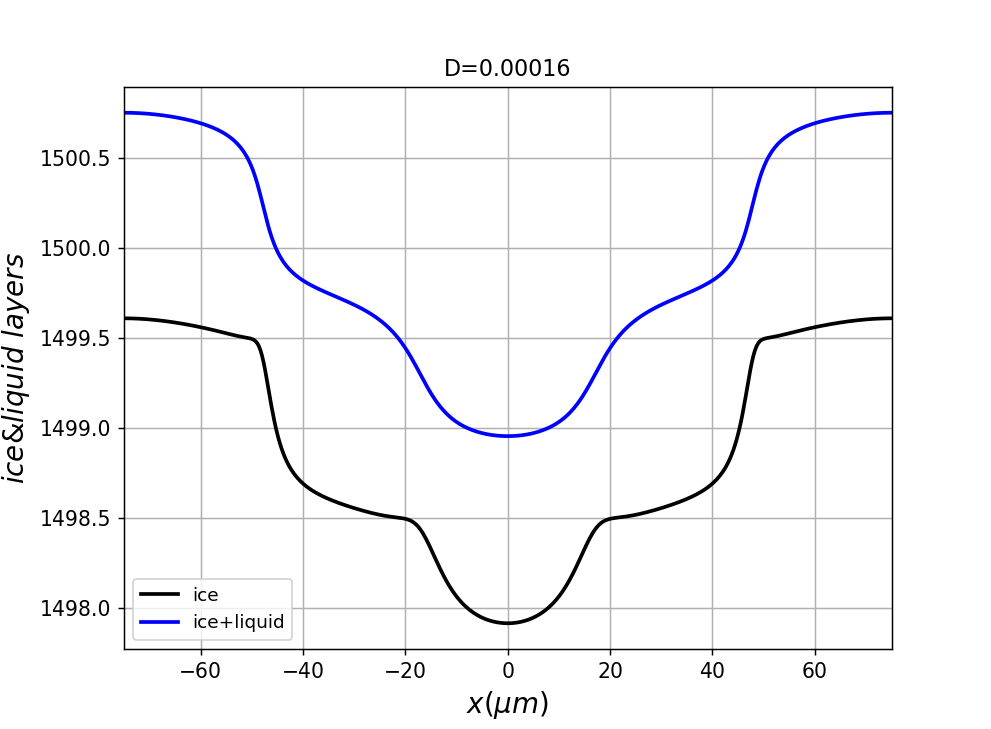

<IPython.core.display.Javascript object>


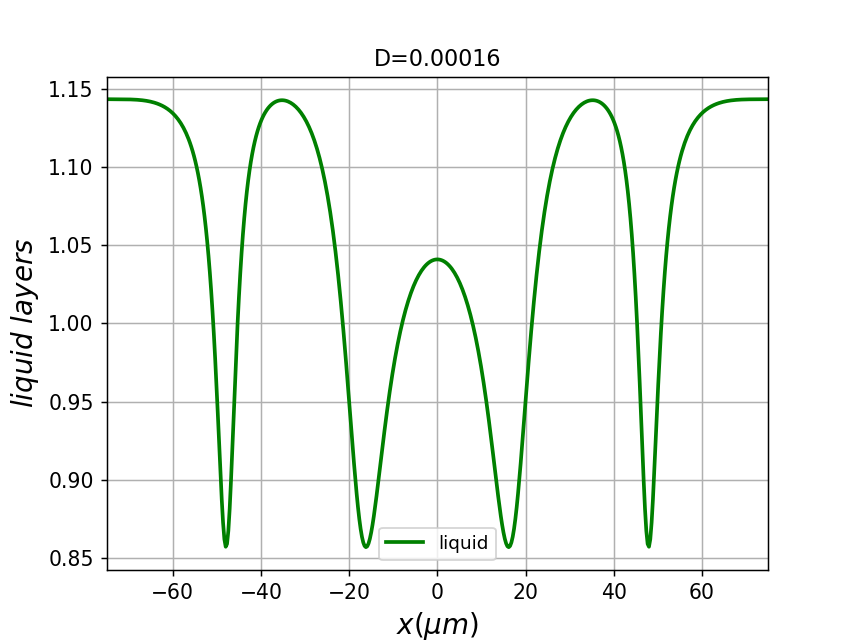

<IPython.core.display.Javascript object>


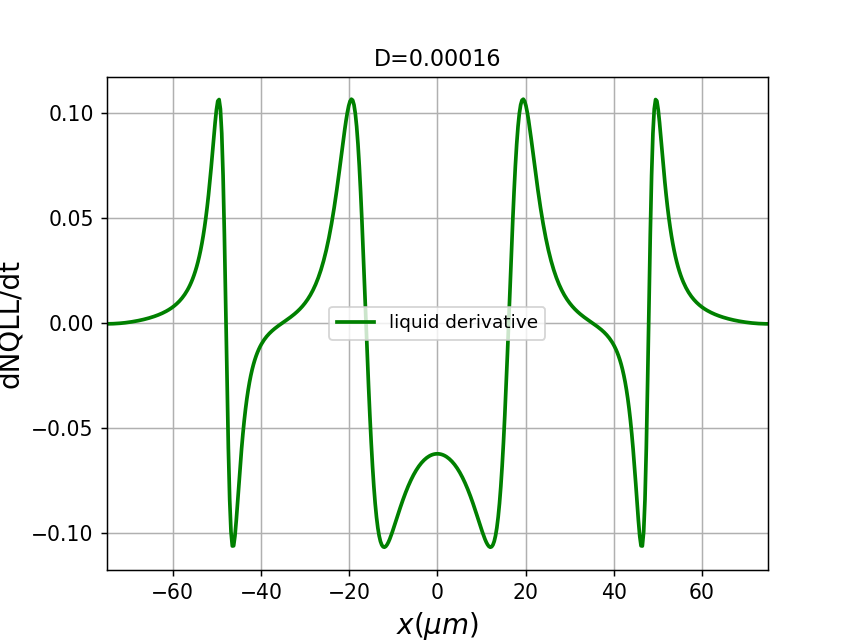

<IPython.core.display.Javascript object>


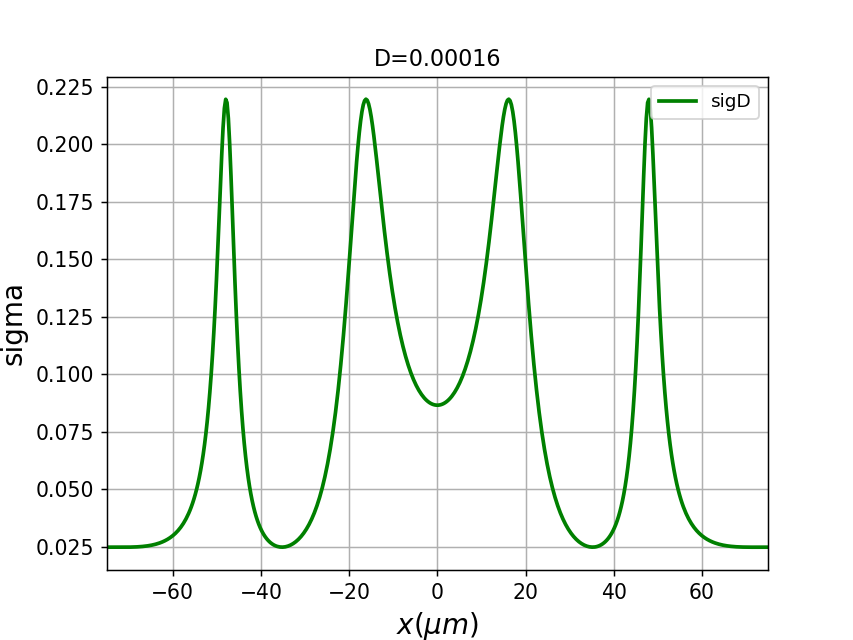

<IPython.core.display.Javascript object>


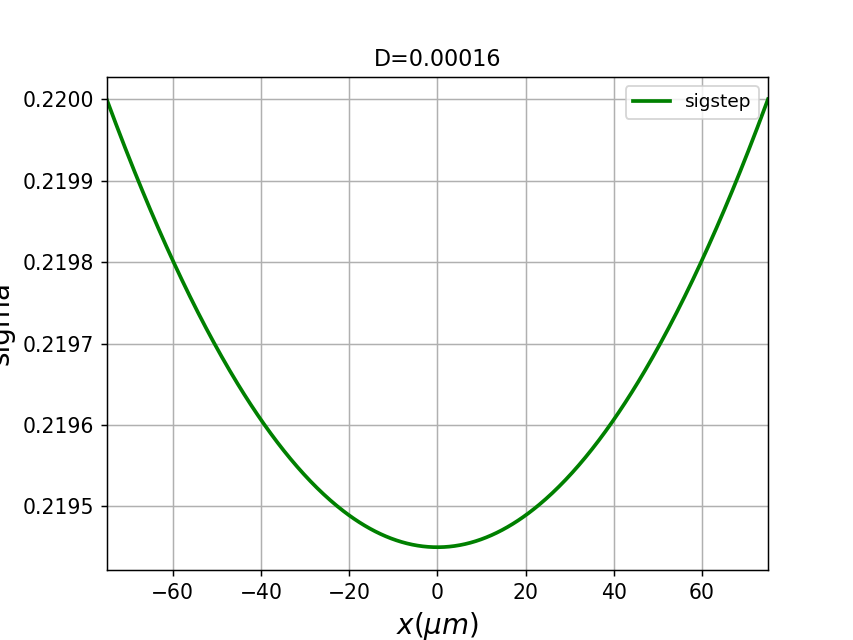

In [13]:
if updatingNQLL:
    title = 'Updating'
else:
    title = 'D='+str(D)

# Plot ice and liquid
plt.figure()
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, NQLL+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot liquid only
plt.figure()
plt.plot(x-xmid, NQLL, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot derivatives
dydx = ds.f1d(ylast,0,params)
dydx = np.reshape(dydx,(2,nx))
plt.figure()
plt.plot(x-xmid, dydx[0,:], 'g', label='liquid derivative', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('dNQLL/dt',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma
sigD = ds.f1d_sigD(ylast,0,params)
plt.figure()
plt.plot(x-xmid, sigD, 'g', label='sigD', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma
plt.figure()
plt.plot(x-xmid, sigmastep, 'g', label='sigstep', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

<IPython.core.display.Javascript object>


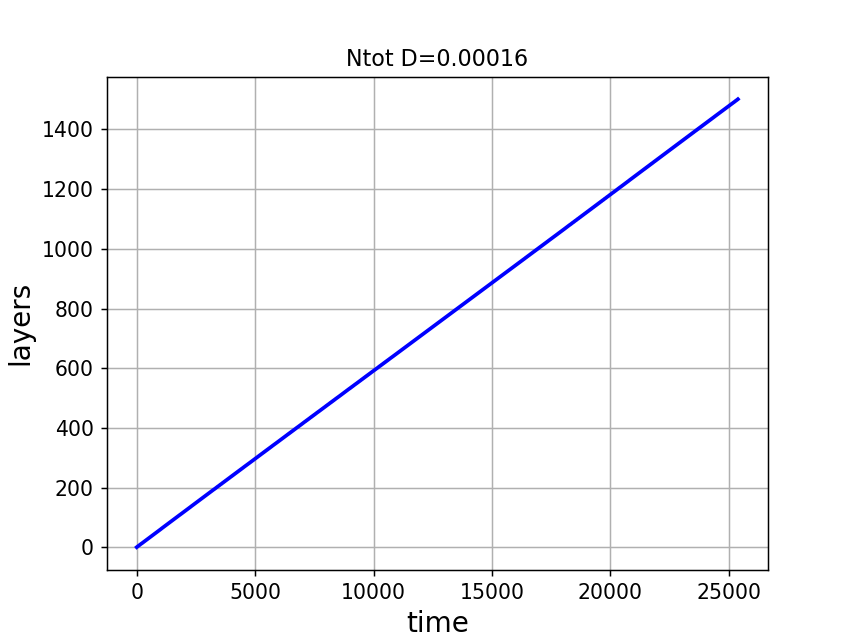

<IPython.core.display.Javascript object>


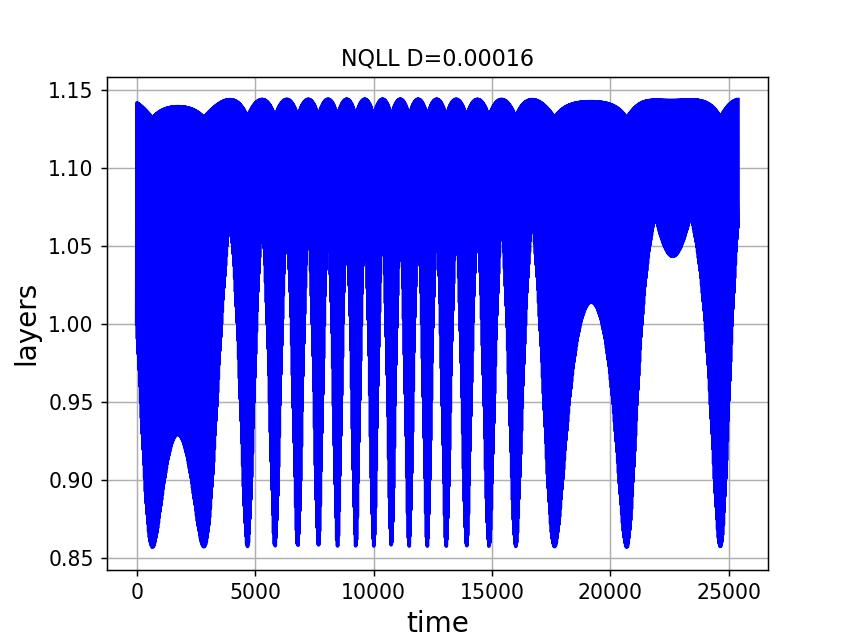

<IPython.core.display.Javascript object>


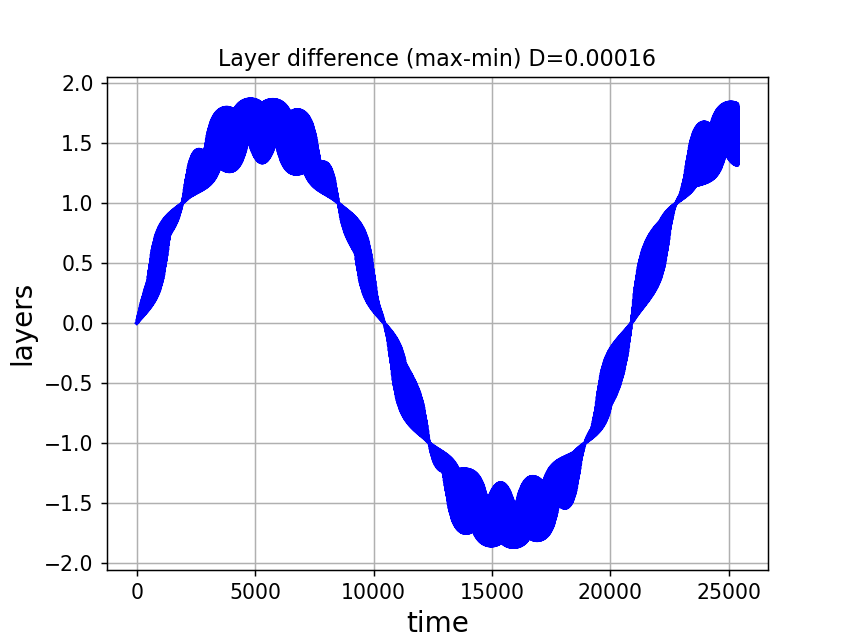

Text(0.5, 1.0, 'Layer difference (max-min) D=0.00016')

In [14]:
# The liquid over time
ix = 0
Ntotkeep_at_one_position = np.array(Ntotkeep)[:,ix]
plt.figure()
plt.plot(tkeep, Ntotkeep_at_one_position, 'b', label='total', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Ntot '+title)

# 
ix = 0
NQLLkeep_at_one_position = np.array(NQLLkeep)[:,ix]
plt.figure()
plt.plot(tkeep, NQLLkeep_at_one_position, 'b', label='liquid', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('NQLL '+title)


Ntot_difference = np.array(Ntotkeep)[:,-1] - np.array(Ntotkeep)[:,nmid]
plt.figure()
plt.plot(tkeep, Ntot_difference, 'b', label='number of steps', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Layer difference (max-min) '+title)

In [22]:
# Some other explorations ... the time required for an initial gaussian to diffuse
layer_growth_rate = growthrate_0d/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
t1 = 1/layer_growth_rate; print('Time_to_add_a_layer =', t1)
t2 = 2.5**2/D; print('Time to diffuse across a terrace =', t2)
t3 = 0.2**2/D; print('Time to diffuse into a step =', t3)
t4 = 0.001; print('Time for ice-QLL equilibration =', t4)

Layer growth rate = 0.05951840609378938
Time_to_add_a_layer = 16.80152520254315
Time to diffuse across a terrace = 39062.5
Time to diffuse into a step = 250.00000000000003
Time for ice-QLL equilibration = 0.001


In [16]:
# How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
D_old = 2e-6
D_new = D_old/50**2*100**2; print(D_new)

8e-06


In [17]:
# Computing the kinetic deposition velocity ... roughly, 260 
import numpy as np
M = 18 # g/mol
T = 260 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
10808.199999999999 Liters
10808199.999999998 cm^3
1.6654021946300035e-06 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
9943543.999999998 ratio of volumes
1.810219776771743e-06 ratio of densities
0.0002502630900698087 kinetic velocity, m/s
250.26309006980867 kinetic velocity, um/s


In [18]:
# Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
import numpy as np
M = 18 # g/mol
T = 240 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
76744.61538461539 Liters
76744615.38461539 cm^3
2.345441424103921e-07 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
70605046.15384616 ratio of volumes
2.5493928522868707e-07 ratio of densities
3.386267075877731e-05 kinetic velocity, m/s
33.86267075877731 kinetic velocity, um/s


In [19]:
# Gladich et al recommendation
D_Gladich = 0.16e-9 # m^2/s
D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)

Gladich says, for 260 K, D =  0.00015999999999999999
